In [1]:
import numpy as np
import  matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,BatchNormalization,MaxPooling2D
from tensorflow.keras.initializers import he_uniform,he_normal
from tensorflow.keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator,array_to_img
from tensorflow.keras.activations import relu
import skimage
from skimage import io
from skimage import data

In [2]:
path_test='I:\Intel_image_classification\seg_test'
path_train='I:\Intel_image_classification\seg_train'

In [3]:
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".jpg")]
        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(d)
            
    return images, labels

In [4]:
images,labels=load_data(path_train)

6


(array([2191., 2271., 2404., 2512., 4656.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

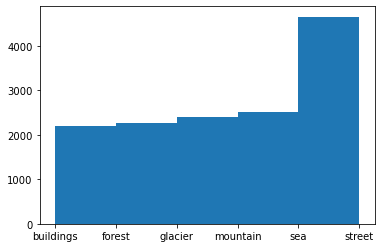

In [5]:
print(len(set(labels)))
plt.hist(labels,5)

In [6]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
vec=le.fit_transform(labels)
y_train=vec

In [7]:
img_h,img_w=(120,120)
train_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2,zoom_range=[0.5, 1.5],channel_shift_range=150.0)
test_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(path_train,
                                                        target_size=(120,120),
                                                        color_mode="rgb",
                                                        batch_size=32,
                                                        class_mode="sparse",
                                                        subset='training',
                                                        shuffle=True,
                                                        seed=42)

## For Validation
validation_generator = train_datagen.flow_from_directory(
path_train,
target_size=(120,120),
batch_size=32,
color_mode="rgb",
class_mode='sparse',
subset='validation')

#For Testing
test_generator = test_datagen.flow_from_directory(path_train,
                                        target_size=(120,120),
                                        color_mode="rgb",
                                        batch_size=1,
                                        class_mode='sparse',
                                        shuffle=False,
                                        seed=42)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 14034 images belonging to 6 classes.


In [20]:
import kerastuner as kt
def my_model(hp):

    model=Sequential()
    weights=hp.Choice('weights',['he_uniform','he_normal'])
    num_block=hp.Int('num_block',min_value=2,max_value=4,step=1)
    num_filters=hp.Int('num_filters',min_value=32,max_value=128,step=32)
    for i in range(num_block):
        
        model.add(Conv2D(num_filters,kernel_size=(3,3),padding='same',kernel_initializer=weights,activation='relu',input_shape=(120,120,3),data_format='channels_last'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters,(3,3),padding='same',kernel_initializer=weights,activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('num_dense_units',min_value=32,max_value=256,step=32),activation='relu',kernel_initializer=weights))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dense_dropout',min_value=0.,max_value=0.5,step=0.1)))
    model.add(Dense(units=hp.Int('num_dense_units_2',min_value=32,max_value=56,step=12),activation='relu',kernel_initializer=weights))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dense_dropout_2',min_value=0.,max_value=0.3,step=0.1)))
    model.add(Dense(6,activation='softmax'))
    learning_rate=hp.Float('learning_rate',min_value=3e-4,max_value=3e-1)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    model.summary()

    return model

In [25]:
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, baseline=0.3)]
mc =tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
tuner=kt.tuners.RandomSearch(my_model,objective='val_accuracy',max_trials=10,directory='my_dir1')

batch_size=128
epochs=20
tuner.search(train_generator,epochs=epochs,batch_size=batch_size,verbose=2,validation_data=validation_generator,callbacks=[callbacks,mc])

INFO:tensorflow:Reloading Oracle from existing project my_dir1\untitled_project\oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 120, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
______________________________

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 00001: val_accuracy improved from -inf to 0.17332, saving model to best_model.h5
351/351 - 56s - loss: 1.7669 - accuracy: 0.2697 - val_loss: 5.5084 - val_accuracy: 0.1733
Epoch 2/20

Epoch 00002: val_accuracy improved from 0.17332 to 0.18224, saving model to best_model.h5
351/351 - 59s - loss: 1.6303 - accuracy: 0.3344 - val_loss: 13.5228 - val_accuracy: 0.1822
Epoch 3/20

Epoch 00003: val_accuracy improved from 0.18224 to 0.32026, saving model to best_model.h5
351/351 - 62s - loss: 1.5708 - accuracy: 0.3626 - val_loss: 10.2021 - val_accuracy: 0.3203
Epoch 4/20

Epoch 00004: val_accuracy improved from 0.32026 to 0.47753, saving model to best_model.h5
351/351 - 62s - loss: 1.4829 - accuracy: 0.3997 - val_loss: 1.3910 - val_accuracy: 0.4775
Epoch 5/20

Epoch 00005: val_accuracy did not improve from 0.47753
351/351 - 58s - loss: 1.3943 - accuracy: 0.4430 - val_loss: 2.4670 - val_accuracy: 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 120, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 64)        2

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 120, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 32)        1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 96)      2688      
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 96)      384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 96)      83040     
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 120, 96)      384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 96)        83040     
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 96)        3

Epoch 17/20

Epoch 00017: val_accuracy did not improve from 0.58845
351/351 - 97s - loss: 1.0710 - accuracy: 0.5784 - val_loss: 17645.1973 - val_accuracy: 0.5478
Epoch 18/20

Epoch 00018: val_accuracy improved from 0.58845 to 0.61555, saving model to best_model.h5
351/351 - 105s - loss: 1.1492 - accuracy: 0.5649 - val_loss: 12562.5361 - val_accuracy: 0.6155
Epoch 19/20

Epoch 00019: val_accuracy did not improve from 0.61555
351/351 - 92s - loss: 1.0200 - accuracy: 0.6030 - val_loss: 45470.5781 - val_accuracy: 0.5531
Epoch 20/20

Epoch 00020: val_accuracy did not improve from 0.61555
351/351 - 94s - loss: 1.1132 - accuracy: 0.5926 - val_loss: 2.1452 - val_accuracy: 0.5653


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 120, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 32)        1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 120, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 64)        2

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 120, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 64)        2

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 120, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 32)        1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 96)      2688      
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 96)      384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 96)      83040     
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 120, 96)      384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 96)        83040     
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 96)        3

INFO:tensorflow:Oracle triggered exit


In [27]:
tuner.get_best_hyperparameters

<bound method BaseTuner.get_best_hyperparameters of <kerastuner.tuners.randomsearch.RandomSearch object at 0x00000216D82D3588>>

In [28]:
loss, mse = best_model.evaluate(test_generator)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


 2700/14034 [====>.........................] - ETA: 13s - loss: 1.7569 - accuracy: 0.0000e+0 - ETA: 50s - loss: 0.3924 - accuracy: 0.8667    - ETA: 50s - loss: 0.2318 - accuracy: 0.931 - ETA: 50s - loss: 0.2334 - accuracy: 0.930 - ETA: 50s - loss: 0.2841 - accuracy: 0.877 - ETA: 51s - loss: 0.2771 - accuracy: 0.885 - ETA: 50s - loss: 0.3448 - accuracy: 0.872 - ETA: 50s - loss: 0.3566 - accuracy: 0.870 - ETA: 51s - loss: 0.3813 - accuracy: 0.867 - ETA: 51s - loss: 0.4094 - accuracy: 0.866 - ETA: 52s - loss: 0.4110 - accuracy: 0.863 - ETA: 51s - loss: 0.3927 - accuracy: 0.869 - ETA: 51s - loss: 0.4019 - accuracy: 0.868 - ETA: 51s - loss: 0.3922 - accuracy: 0.862 - ETA: 51s - loss: 0.3773 - accuracy: 0.868 - ETA: 50s - loss: 0.3543 - accuracy: 0.877 - ETA: 50s - loss: 0.3516 - accuracy: 0.876 - ETA: 50s - loss: 0.3579 - accuracy: 0.880 - ETA: 50s - loss: 0.3599 - accuracy: 0.879 - ETA: 50s - loss: 0.3616 - accuracy: 0.878 - ETA: 49s - loss: 0.3551 - accuracy: 0.881 - ETA: 49s - loss: 0.34

 5417/14034 [==========>...................] - ETA: 42s - loss: 0.3586 - accuracy: 0.889 - ETA: 41s - loss: 0.3568 - accuracy: 0.890 - ETA: 41s - loss: 0.3553 - accuracy: 0.891 - ETA: 41s - loss: 0.3537 - accuracy: 0.891 - ETA: 41s - loss: 0.3520 - accuracy: 0.892 - ETA: 41s - loss: 0.3502 - accuracy: 0.892 - ETA: 41s - loss: 0.3486 - accuracy: 0.893 - ETA: 41s - loss: 0.3471 - accuracy: 0.893 - ETA: 41s - loss: 0.3456 - accuracy: 0.894 - ETA: 41s - loss: 0.3448 - accuracy: 0.894 - ETA: 41s - loss: 0.3434 - accuracy: 0.895 - ETA: 41s - loss: 0.3418 - accuracy: 0.895 - ETA: 41s - loss: 0.3413 - accuracy: 0.895 - ETA: 41s - loss: 0.3405 - accuracy: 0.896 - ETA: 41s - loss: 0.3390 - accuracy: 0.896 - ETA: 41s - loss: 0.3390 - accuracy: 0.896 - ETA: 41s - loss: 0.3381 - accuracy: 0.896 - ETA: 41s - loss: 0.3368 - accuracy: 0.897 - ETA: 40s - loss: 0.3368 - accuracy: 0.897 - ETA: 40s - loss: 0.3354 - accuracy: 0.897 - ETA: 40s - loss: 0.3338 - accuracy: 0.898 - ETA: 40s - loss: 0.3334 - acc

 8119/14034 [================>.............] - ETA: 31s - loss: 0.4010 - accuracy: 0.871 - ETA: 31s - loss: 0.4038 - accuracy: 0.870 - ETA: 31s - loss: 0.4057 - accuracy: 0.869 - ETA: 30s - loss: 0.4064 - accuracy: 0.869 - ETA: 30s - loss: 0.4082 - accuracy: 0.868 - ETA: 30s - loss: 0.4112 - accuracy: 0.868 - ETA: 30s - loss: 0.4141 - accuracy: 0.867 - ETA: 30s - loss: 0.4154 - accuracy: 0.866 - ETA: 30s - loss: 0.4179 - accuracy: 0.865 - ETA: 30s - loss: 0.4175 - accuracy: 0.866 - ETA: 30s - loss: 0.4197 - accuracy: 0.864 - ETA: 30s - loss: 0.4212 - accuracy: 0.864 - ETA: 30s - loss: 0.4239 - accuracy: 0.863 - ETA: 30s - loss: 0.4262 - accuracy: 0.862 - ETA: 30s - loss: 0.4292 - accuracy: 0.861 - ETA: 30s - loss: 0.4310 - accuracy: 0.860 - ETA: 30s - loss: 0.4316 - accuracy: 0.860 - ETA: 30s - loss: 0.4331 - accuracy: 0.859 - ETA: 29s - loss: 0.4338 - accuracy: 0.859 - ETA: 29s - loss: 0.4356 - accuracy: 0.858 - ETA: 29s - loss: 0.4361 - accuracy: 0.858 - ETA: 29s - loss: 0.4376 - acc

10747/14034 [=====================>........] - ETA: 21s - loss: 0.4926 - accuracy: 0.833 - ETA: 21s - loss: 0.4921 - accuracy: 0.833 - ETA: 21s - loss: 0.4915 - accuracy: 0.833 - ETA: 21s - loss: 0.4911 - accuracy: 0.833 - ETA: 21s - loss: 0.4908 - accuracy: 0.834 - ETA: 21s - loss: 0.4901 - accuracy: 0.834 - ETA: 20s - loss: 0.4896 - accuracy: 0.834 - ETA: 20s - loss: 0.4896 - accuracy: 0.834 - ETA: 20s - loss: 0.4891 - accuracy: 0.834 - ETA: 20s - loss: 0.4885 - accuracy: 0.834 - ETA: 20s - loss: 0.4880 - accuracy: 0.835 - ETA: 20s - loss: 0.4874 - accuracy: 0.835 - ETA: 20s - loss: 0.4869 - accuracy: 0.835 - ETA: 20s - loss: 0.4866 - accuracy: 0.835 - ETA: 20s - loss: 0.4864 - accuracy: 0.835 - ETA: 20s - loss: 0.4863 - accuracy: 0.835 - ETA: 20s - loss: 0.4860 - accuracy: 0.835 - ETA: 20s - loss: 0.4857 - accuracy: 0.835 - ETA: 20s - loss: 0.4855 - accuracy: 0.835 - ETA: 20s - loss: 0.4852 - accuracy: 0.835 - ETA: 20s - loss: 0.4845 - accuracy: 0.836 - ETA: 20s - loss: 0.4845 - acc

13454/14034 [===========================>..] - ETA: 11s - loss: 0.5531 - accuracy: 0.803 - ETA: 11s - loss: 0.5537 - accuracy: 0.803 - ETA: 11s - loss: 0.5545 - accuracy: 0.803 - ETA: 11s - loss: 0.5550 - accuracy: 0.803 - ETA: 11s - loss: 0.5550 - accuracy: 0.803 - ETA: 11s - loss: 0.5553 - accuracy: 0.803 - ETA: 11s - loss: 0.5556 - accuracy: 0.802 - ETA: 11s - loss: 0.5564 - accuracy: 0.802 - ETA: 11s - loss: 0.5572 - accuracy: 0.802 - ETA: 11s - loss: 0.5576 - accuracy: 0.802 - ETA: 11s - loss: 0.5577 - accuracy: 0.802 - ETA: 11s - loss: 0.5581 - accuracy: 0.801 - ETA: 11s - loss: 0.5593 - accuracy: 0.801 - ETA: 11s - loss: 0.5601 - accuracy: 0.800 - ETA: 11s - loss: 0.5610 - accuracy: 0.800 - ETA: 11s - loss: 0.5620 - accuracy: 0.799 - ETA: 11s - loss: 0.5632 - accuracy: 0.799 - ETA: 11s - loss: 0.5636 - accuracy: 0.799 - ETA: 10s - loss: 0.5642 - accuracy: 0.799 - ETA: 10s - loss: 0.5642 - accuracy: 0.799 - ETA: 10s - loss: 0.5658 - accuracy: 0.798 - ETA: 10s - loss: 0.5666 - acc

14034/14034 [==============================] - ETA: 2s - loss: 0.5893 - accuracy: 0.78 - ETA: 2s - loss: 0.5894 - accuracy: 0.78 - ETA: 1s - loss: 0.5891 - accuracy: 0.78 - ETA: 1s - loss: 0.5888 - accuracy: 0.78 - ETA: 1s - loss: 0.5884 - accuracy: 0.78 - ETA: 1s - loss: 0.5884 - accuracy: 0.78 - ETA: 1s - loss: 0.5886 - accuracy: 0.78 - ETA: 1s - loss: 0.5883 - accuracy: 0.78 - ETA: 1s - loss: 0.5882 - accuracy: 0.78 - ETA: 1s - loss: 0.5883 - accuracy: 0.78 - ETA: 1s - loss: 0.5880 - accuracy: 0.78 - ETA: 1s - loss: 0.5880 - accuracy: 0.78 - ETA: 1s - loss: 0.5879 - accuracy: 0.78 - ETA: 1s - loss: 0.5875 - accuracy: 0.78 - ETA: 1s - loss: 0.5872 - accuracy: 0.78 - ETA: 1s - loss: 0.5873 - accuracy: 0.78 - ETA: 1s - loss: 0.5875 - accuracy: 0.78 - ETA: 1s - loss: 0.5871 - accuracy: 0.78 - ETA: 1s - loss: 0.5872 - accuracy: 0.78 - ETA: 1s - loss: 0.5871 - accuracy: 0.78 - ETA: 1s - loss: 0.5869 - accuracy: 0.78 - ETA: 1s - loss: 0.5870 - accuracy: 0.78 - ETA: 0s - loss: 0.5869 - accu

In [29]:
mse

0.7863759398460388

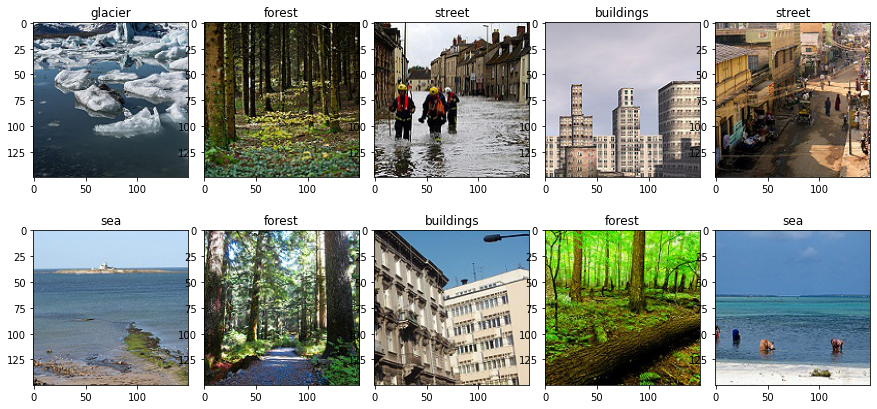

In [42]:
pred_path='I:\Intel_image_classification\seg_pred'
from skimage import transform
from skimage.color import rgb2gray
number_of_total_test_data=len([name for name in os.listdir(pred_path)])

#lets run test for 5 images
fig, axs = plt.subplots(2,5, figsize=(15, 7), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.1)

axs = axs.ravel()

for i in range(10):
    x=np.random.choice([x for x in os.listdir(pred_path)if os.path.isfile(os.path.join(pred_path,x))])
    pred_image=skimage.io.imread(os.path.join(pred_path,x))
    axs[i].imshow(pred_image)
    pred_image_trans=transform.resize(pred_image,(120,120))
    #pred_image_trans= rgb2gray(pred_image_trans)
    pred_image_trans=pred_image_trans.reshape(1,pred_image_trans.shape[0],pred_image_trans.shape[1],
                                              pred_image_trans.shape[2]).astype('float32')
    predic=best_model.predict(pred_image_trans)
    p=np.argmax(predic)
    p=[p,]
    s=np.array(p)
    predicted_class=le.inverse_transform(s)
    class_=predicted_class[0]
    axs[i].title.set_text(class_)
    
    